In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.options.display.max_columns = None

import os
import argparse
import pickle
import torch
import json

import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import DataLoader
from ESIM.esim.data import NLIDataset
from ESIM.esim.model import ESIM
from ESIM.utils import train, validate

# Competation Model

## prepare bd data

In [6]:
train_data = pd.read_csv('ESIM/data/train_data.sample',sep=',',names=['query_id','query','query_title_id','title','label'])
train_data.head()

,query_id,query,query_title_id,title,label
0,1,1427 5661 29788 1427 387 2299 372 22 1586 1025...,1,3447 11146 364 5113 27 19990 36 377411 41977 5...,1
1,1,1427 5661 29788 1427 387 2299 372 22 1586 1025...,2,3447 24 5661 29788 23 75 1678 27 19133 123 29 ...,0
2,1,1427 5661 29788 1427 387 2299 372 22 1586 1025...,3,372 22 1586 1025 24 391 23 27 7092 22 266 2581...,1
3,2,1427 5661 29788 1427 361 22 1374 279 1196 27 7...,1,46829 43659 337 68 650 78 78 22268 2846 428 11...,0
4,2,1427 5661 29788 1427 361 22 1374 279 1196 27 7...,2,372 22 1586 1025 24 391 23 27 7092 22 266 2581...,1


In [7]:
train_data['query_len'] = train_data['query'].apply(lambda x: len(x.split(' ')))
train_data['title_len'] = train_data['title'].apply(lambda x: len(x.split(' ')))

In [8]:
train_data.describe()

,query_id,query_title_id,label,query_len,title_len
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,1501.647400,5.743900,0.251750,4.02625,13.699550
std,868.915712,4.706136,0.434029,8.34276,4.223467
min,1.000000,1.000000,0.000000,1.00000,1.000000
25%,733.000000,2.000000,0.000000,3.00000,11.000000
50%,1505.000000,4.000000,0.000000,3.00000,14.000000
75%,2266.000000,8.000000,1.000000,4.00000,17.000000
max,2991.000000,20.000000,1.000000,300.00000,35.000000


In [9]:
query_set = set(' '.join(train_data['query']).split())
title_set = set(' '.join(train_data['title']).split())
word_set = query_set | title_set | {'</s>', 'pos', 'pad'}
len(word_set)

36205

In [10]:
## build embeddings_index
embeddings_index = {}
f = open('ESIM/data/embeddings/w2v_model')
i = 0
for line in f:
    if i ==0:  
        i+=1
        continue
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
## embeddings_index 包含所有w2v词向量词汇
print('Loaded {} word vectors'.format(len(embeddings_index)))

for i in set(embeddings_index.keys()):
    if i not in word_set:
        del embeddings_index[i]
print('Loaded {} word vectors'.format(len(embeddings_index)))


Loaded 9334 word vectors
Loaded 9334 word vectors


In [11]:
## build word_to_indices
word_to_indices = {}
indices = 0
controlnum = 50000 
#for word in embeddings_index.keys()
word_to_indices['</s>'] = 0  # end
indices += 1 
word_to_indices['pad'] = 1   # pad
indices += 1 
word_to_indices['pos'] = 2   # no find its word means not in embedmatrix or not in texts
indices += 1 
for word in embeddings_index.keys():
    if word in ['</s>', 'pad', 'pos']: continue
    word_to_indices[word] = indices
    indices += 1
    #if indices > controlnum: break
print(indices, 'words in train and test texts')
#word_to_indices
#embeddings_index

9336 words in train and test texts


In [12]:
## build embedding_matrix
print('Preparing embeddings matrix...')
mean_word_vector = np.mean(list(embeddings_index.values()), axis=0)
embedding_dim = len(list(embeddings_index.values())[0])
num_words = len(word_to_indices)
embedding_matrix = np.zeros((num_words, embedding_dim))
found_words = 0
lost = 0
for word in word_to_indices.keys():
    try:
        index = word_to_indices[word]
        embedding_vector = embeddings_index[word]
        embedding_matrix[index] = embedding_vector
        found_words += 1
    except:
        lost += 1
        print(word)
#embedding_matrix[word_to_indices[word]] = mean_word_vector
embedding_matrix[word_to_indices['pad']] = np.zeros(embedding_dim)
embedding_matrix[word_to_indices['pos']] = mean_word_vector
print('{} words find {} lost in our vocabulary had {} vectors and appear more than the min frequency'.format(
    found_words, lost, 'w2v'))
embedding_matrix

Preparing embeddings matrix...
pad
pos
9334 words find 2 lost in our vocabulary had w2v vectors and appear more than the min frequency


array([[ 0.001334  ,  0.001473  , -0.001277  , ..., -0.000437  ,
        -0.000552  ,  0.001024  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04778017,  0.05877438,  0.01306976, ...,  0.07009552,
         0.11916532, -0.02359138],
       ...,
       [ 0.032018  ,  0.040095  ,  0.0102    , ...,  0.046912  ,
         0.081305  , -0.017075  ],
       [ 0.015211  ,  0.020207  ,  0.005791  , ...,  0.024457  ,
         0.04116   , -0.00905   ],
       [ 0.024455  ,  0.031674  ,  0.008066  , ...,  0.037374  ,
         0.062463  , -0.011518  ]])

In [13]:
tokens = []
for row in train_data['query']:
    tokens.append(row.split(' '))

sequences_query = [[word_to_indices[i]  for i in t if i in word_to_indices]+[0] for t in tokens]
#padded_seq_query = [pad_sequences(s, maxlen=25, pad_idx=max_indices) for s in sequences_query]
#sequences_query
print(max([len(i) for i in sequences_query]), min([len(i) for i in sequences_query]))

253 1


In [14]:
tokens = []
for row in train_data['title']:
    tokens.append(row.split(' '))

sequences_title = [[word_to_indices[i] for i in t if i in word_to_indices] + [0]  for t in tokens]
#padded_seq_query = [pad_sequences(s, maxlen=35, pad_idx=max_indices) for s in sequences_title]
#sequences_title
print(max([len(i) for i in sequences_title]), min([len(i) for i in sequences_title]))

32 1


## train dataset

In [15]:
train_idx= [[train_data['query_id'][i], train_data['query_title_id'][i]] for i in range(train_data.shape[0])]
#train_idx

In [16]:
len(sequences_query)

20000

In [17]:
#dict_keys(['ids', 'premises', 'hypotheses', 'labels'])

split_num = int(20000*0.8)

train_esmim = {
    'ids': train_idx[:split_num],
    'premises': sequences_query[:split_num],
    'hypotheses': sequences_title[:split_num],
    'labels': list(train_data['label'][:split_num])
}

valid_esmim = {
    'ids': train_idx[split_num:],
    'premises': sequences_query[split_num:],
    'hypotheses': sequences_title[split_num:],
    'labels': list(train_data['label'][split_num:])
}

## model

In [32]:
'''
    "hidden_size": 300,
    "dropout": 0.5,
    "num_classes": 3,

    "epochs": 64,
    "batch_size": 32,
    "lr": 0.0004,
    "patience": 5,
    "max_gradient_norm": 10.0
'''
hidden_size = 300
dropout = 0.3
num_classes = 2
epochs = 5
batch_size = 256
lr = 0.0004
patience = 5
max_grad_norm = 10
checkpoint = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
save_flag = False
#target_dir = 'data/checkpoints/'

#device = torch.device('cpu')

In [33]:
print("\t* Loading training data...")
Ntrain = NLIDataset(train_esmim, padding_idx=1, max_premise_length=10, max_hypothesis_length=25)
Nvalid = NLIDataset(valid_esmim, padding_idx=1, max_premise_length=10, max_hypothesis_length=25)
train_loader = DataLoader(Ntrain, shuffle=False, batch_size=batch_size)
valid_loader = DataLoader(Nvalid, shuffle=False, batch_size=batch_size)
embeddings = torch.tensor(embedding_matrix, dtype=torch.float).to(device)

	* Loading training data...


/root/kaggle/BDnlp/ESIM/esim/utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))
Avg. batch proc. time: 0.0796s, loss: 0.6520:   3%|▎         | 2/63 [00:00<00:05, 11.96it/s]

	* Validation loss before training: 0.6823, accuracy: 75.3500%

 ==================== Training ESIM model on device: cuda:0 ====================
* Training epoch 1:


Avg. batch proc. time: 0.0758s, loss: 0.5762: 100%|██████████| 63/63 [00:05<00:00, 12.51it/s]


-> Training time: 5.0355s, loss = 0.5762, accuracy: 74.5312%
* Validation for epoch 1:


Avg. batch proc. time: 0.0781s, loss: 0.6080:   3%|▎         | 2/63 [00:00<00:05, 12.15it/s]

-> Valid. time: 0.4353s, loss: 0.5679, accuracy: 75.3500%

* Training epoch 2:


Avg. batch proc. time: 0.0757s, loss: 0.5687: 100%|██████████| 63/63 [00:05<00:00, 12.52it/s]


-> Training time: 5.0317s, loss = 0.5687, accuracy: 74.6938%
* Validation for epoch 2:


Avg. batch proc. time: 0.0757s, loss: 0.6085:   3%|▎         | 2/63 [00:00<00:04, 12.62it/s]

-> Valid. time: 0.4039s, loss: 0.5683, accuracy: 75.3500%

* Training epoch 3:


Avg. batch proc. time: 0.0760s, loss: 0.5654: 100%|██████████| 63/63 [00:05<00:00, 12.49it/s]


-> Training time: 5.0454s, loss = 0.5654, accuracy: 74.6938%
* Validation for epoch 3:


Avg. batch proc. time: 0.0757s, loss: 0.6089:   3%|▎         | 2/63 [00:00<00:04, 12.57it/s]

-> Valid. time: 0.4020s, loss: 0.5598, accuracy: 75.3500%

* Training epoch 4:


Avg. batch proc. time: 0.0757s, loss: 0.5614: 100%|██████████| 63/63 [00:05<00:00, 12.55it/s]


-> Training time: 5.0202s, loss = 0.5614, accuracy: 74.6938%
* Validation for epoch 4:


Avg. batch proc. time: 0.0784s, loss: 0.6125:   3%|▎         | 2/63 [00:00<00:05, 12.13it/s]

-> Valid. time: 0.4026s, loss: 0.5590, accuracy: 75.3500%

* Training epoch 5:


Avg. batch proc. time: 0.0764s, loss: 0.5574: 100%|██████████| 63/63 [00:05<00:00, 12.41it/s]


-> Training time: 5.0783s, loss = 0.5574, accuracy: 74.6938%
* Validation for epoch 5:
-> Valid. time: 0.4073s, loss: 0.5592, accuracy: 75.3500%



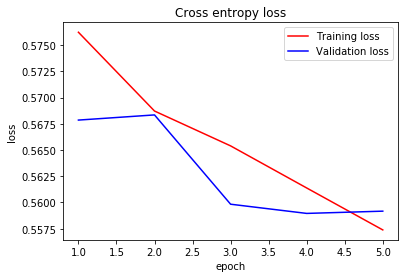

In [34]:
model = ESIM(embeddings.shape[0],
             embeddings.shape[1],
             hidden_size,
             embeddings=embeddings,
             padding_idx=1,
             dropout=dropout,
             num_classes=num_classes,
             device=device).to(device)

# -------------------- Preparation for training  ------------------- #
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="max",
                                                       factor=0.5,
                                                       patience=0)

best_score = 0.0
start_epoch = 1

# Data for loss curves plot.
epochs_count = []
train_losses = []
valid_losses = []

# Continuing training from a checkpoint if one was given as argument.
if checkpoint:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint["epoch"] + 1
    best_score = checkpoint["best_score"]

    print("\t* Training will continue on existing model from epoch {}..."
          .format(start_epoch))

    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epochs_count = checkpoint["epochs_count"]
    train_losses = checkpoint["train_losses"]
    valid_losses = checkpoint["valid_losses"]

# Compute loss and accuracy before starting (or resuming) training.
_, valid_loss, valid_accuracy, prob = validate(model,
                                         valid_loader,
                                         criterion)
print("\t* Validation loss before training: {:.4f}, accuracy: {:.4f}%"
      .format(valid_loss, (valid_accuracy*100)))

# -------------------- Training epochs ------------------- #
print("\n",
      20 * "=",
      "Training ESIM model on device: {}".format(device),
      20 * "=")

patience_counter = 0
for epoch in range(start_epoch, epochs+1):
    epochs_count.append(epoch)

    print("* Training epoch {}:".format(epoch))
    epoch_time, epoch_loss, epoch_accuracy = train(model,
                                                   train_loader,
                                                   optimizer,
                                                   criterion,
                                                   epoch,
                                                   max_grad_norm)

    train_losses.append(epoch_loss)
    print("-> Training time: {:.4f}s, loss = {:.4f}, accuracy: {:.4f}%"
          .format(epoch_time, epoch_loss, (epoch_accuracy*100)))

    print("* Validation for epoch {}:".format(epoch))
    epoch_time, epoch_loss, epoch_accuracy, prob = validate(model,
                                                      valid_loader,
                                                      criterion)

    valid_losses.append(epoch_loss)
    print("-> Valid. time: {:.4f}s, loss: {:.4f}, accuracy: {:.4f}%\n"
          .format(epoch_time, epoch_loss, (epoch_accuracy*100)))

    # Update the optimizer's learning rate with the scheduler.
    scheduler.step(epoch_accuracy)

    # Early stopping on validation accuracy.
    if epoch_accuracy < best_score:
        patience_counter += 1
    else:
        best_score = epoch_accuracy
        patience_counter = 0
#         Save the best model. The optimizer is not saved to avoid having
#         a checkpoint file that is too heavy to be shared. To resume
#         training from the best model, use the 'esim_*.pth.tar'
#         checkpoints instead.
        if save_flag:
            torch.save({"epoch": epoch,
                        "model": model.state_dict(),
                        "best_score": best_score,
                        "epochs_count": epochs_count,
                        "train_losses": train_losses,
                        "valid_losses": valid_losses},
                       os.path.join(target_dir, "best.pth.tar"))

    # Save the model at each epoch.
    if save_flag:
        torch.save({"epoch": epoch,
                    "model": model.state_dict(),
                    "best_score": best_score,
                    "optimizer": optimizer.state_dict(),
                    "epochs_count": epochs_count,
                    "train_losses": train_losses,
                    "valid_losses": valid_losses},
                   os.path.join(target_dir, "esim_{}.pth.tar".format(epoch)))

    if patience_counter >= patience:
        print("-> Early stopping: patience limit reached, stopping...")
        break

# Plotting of the loss curves for the train and validation sets.
plt.figure()
plt.plot(epochs_count, train_losses, "-r")
plt.plot(epochs_count, valid_losses, "-b")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Training loss", "Validation loss"])
plt.title("Cross entropy loss")
plt.show()

In [37]:
from ESIM.esim.utils import correct_predictions
import time

model.eval()
device = model.device

epoch_start = time.time()
running_loss = 0.0
running_accuracy = 0.0
flag = 0
with torch.no_grad():
    for batch in valid_loader:
        premises = batch["premise"].to(device)
        premises_lengths = batch["premise_length"].to(device)
        hypotheses = batch["hypothesis"].to(device)
        hypotheses_lengths = batch["hypothesis_length"].to(device)
        labels = batch["label"].to(device)

        logits, probs = model(premises,
                              premises_lengths,
                              hypotheses,
                              hypotheses_lengths)
        loss = criterion(logits, labels)
        
        try:
            result = np.append(result, np.array(probs.cpu()), axis=0)
        except:
            result = np.array(probs.cpu())

        running_loss += loss.item()
        #print(running_loss, loss.item())
        running_accuracy += correct_predictions(probs, labels)

    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / (len(valid_loader)-1)
    epoch_accuracy = running_accuracy / (len(valid_loader.dataset))
    
result.shape

/root/kaggle/BDnlp/ESIM/esim/utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))


(4000, 2)

## 验证Qauc

In [38]:
import tqdm
from sklearn.metrics import roc_auc_score,auc

def metric_auc(true,predict):
    '''
    true:      DataFrame , ['query_id','query_title_id','label']
    predict:   np.array , [0.79,0.03,0.56,...]
    '''
    true = pd.concat([true.reset_index(drop=True),pd.DataFrame(predict)],axis=1)
    true.columns = ['query_id','query_title_id','label','predict']

    auc_score = []
    group_df = true.groupby(['query_id'])
    for i in tqdm.tqdm(true['query_id'].drop_duplicates()):
        try:
            tmp = true.iloc[group_df.groups[i]]
            auc_score.append(roc_auc_score(tmp['label'], tmp['predict']))
        except:
            auc_score.append(0.5)  

    return np.mean(auc_score)

pred = result[:,1]
metric_auc(train_data[['query_id','query_title_id','label']][split_num:], pred)

100%|██████████| 579/579 [00:00<00:00, 1591.83it/s]


0.5274531959113742

mean =  0    0.259953
dtype: float32 min =  0    0.164779
dtype: float32 max =  0    0.416775
dtype: float32


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f883c09ff60>]],
      dtype=object)

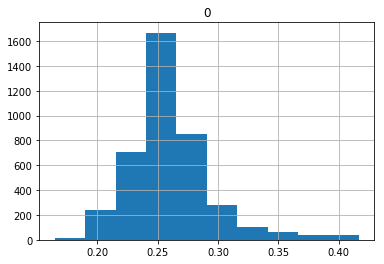

In [39]:
pred_df = pd.DataFrame(pred)
print('mean = ', pred_df.mean(), 'min = ', pred_df.min(), 'max = ',  pred_df.max())
pred_df.hist()